<a href="https://colab.research.google.com/github/savid97/Projects/blob/main/Covid_non_temporal_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a id='main' name="main"></a>
# Viral Data Analysis

Date: 2021.10.12

Author: © 2021 [Yusef Savid](https://www.linkedin.com/in/yusef-savid-651025149/)

This notebook is part of an individual project for [KTU IF](https://fi.ktu.edu/)  [P176M010 Advanced Machine Learning](https://admissions.ktu.edu/programme/m-software-engineering/#P176M010) class led by [M. Lukoševičius](http://mantas.info/).

Here we analyze open COVID-19 data from [Our World in Data](https://ourworldindata.org/) to answer the following questions:

1. [Taking into account the last record of every country before vaccines were introduced , what pairs of additional/added features(Zinc deficiency ,Hours of sunshine per year , Arrivals per country ,Human freedom index and Global hunger index) and dependent variables (total cases , total deaths and others) have an R value higher than 0.2 ?](#Q1)
1. [Taking into account global data , how does new daily cases and 'Covid 19 testing' google trends search interest correlate?](#Q2)
1. [After building a regression model using the added features mentioned in the first question , does the RMSE of the model decrease?](#Q3)

We additionally used data from:
* Datasets on zinc and global hunger index : https://ourworldindata.org/micronutrient-deficiency
* Dataset on arrivals into countries https://www.kaggle.com/ayushggarg/international-tourism-demographics?select=API_ST.INT.ARVL_DS2_en_csv_v2_1927083.csv 
* Dataset on Human freedom index https://www.kaggle.com/gsutters/the-human-freedom-index
* Dataset on Sunshine duration per country
https://en.wikipedia.org/wiki/List_of_cities_by_sunshine_duration
* Dataset on search interest results https://trends.google.com/trends

This notebook is partially based on:
* Work by lecturer M. Lukoševičius

This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International license</a>. <a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons licencija" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/80x15.png" /></a> 

### The main question i am trying to answer is why do some countries have a harder time when dealing with the pandemic .This is done by only taking into account the last record for every country in the dataset , adding certain extra features that might help build a better model to predict the total cases for a particular country .Thus i only include certain features (I mostly dropped any features and dependant variables that include the word "new" as those are daily recordings). I have also dropped all datapoints after the the 1st of december of 2020(as thats about when vaccinations started) as i believe that i would have a less biased model . Naturally , countries who vaccinated a large portion of their population would probably have lower levels of total cases and/or total deaths. 

## Load the data

In [ ]:
#importing libraries used
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import math

Download the data to cache locally. Do this once (a day), and comment out, not to DoS the server. (adopted from https://stackoverflow.com/a/35997720).

In [ ]:
"""
import requests
fname = 'owid-covid-data.csv'
url = 'https://covid.ourworldindata.org/data/' + fname
r = requests.get(url)
open(fname, 'wb').write(r.content)
"""

"\nimport requests\nfname = 'owid-covid-data.csv'\nurl = 'https://covid.ourworldindata.org/data/' + fname\nr = requests.get(url)\nopen(fname, 'wb').write(r.content)\n"

Load the file to Pandas.

In [ ]:
#url = "https://covid.ourworldindata.org/data/owid-covid-data.csv"
# download the file locally when developing, not to DoS the server:
loc_covid_data = "owid-covid-data.csv" #main dataset 
#datasets for the first question
loc_arrivals = "API_ST.INT.ARVL_DS2_en_csv_v2_1927083.csv"#arrivals per year dataset
loc_zinc_def = "global-prevalence-of-zinc-deficiency.csv"#percentage of people with zinc defficency per country dataset
loc_hunger_ind = "global-hunger-index.csv" #golabal hunger index dataset|
loc_hfi_data ="/home/yusef/Desktop/Semester 1/A ML/HFI/hfi_cc_2020.csv"#human freedom index dataset
loc_sunshine_data = "Sunshine per country per month  - Sheet1.csv" #sunshine in hours per country
#datasets for the second question
covtest_search1 = "Covid_19_search_interest.csv"
#reading all the csv files
df = pd.read_csv(loc_covid_data, parse_dates=[3])
#first question datasets
hfi = pd.read_csv(loc_hfi_data)
sun = pd.read_csv(loc_sunshine_data)
arriv = pd.read_csv(loc_arrivals)
zinc = pd.read_csv(loc_zinc_def)
hunger_i = pd.read_csv(loc_hunger_ind)
#second question dataset
covtest_search = pd.read_csv(covtest_search1 , header = [1] , parse_dates=[0])

First 5 rows of the main dataframe

In [ ]:
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


Check the columns available.

In [ ]:
df.columns.values

array(['iso_code', 'continent', 'location', 'date', 'total_cases',
       'new_cases', 'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate',
       'icu_patients', 'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units',
       'total_vaccinations', 'people_vaccinated',
       'people_fully_vaccinated', 'total_boosters', 'new_vaccinations',
       'new_vaccinations_smoothed', 't

The columns are explained [here](https://github.com/owid/covid-19-data/blob/master/public/data/owid-covid-codebook.csv).

Description of the main dataframe

In [ ]:
df.describe()

,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
count,1.139030e+05,113900.000000,112885.000000,1.031510e+05,103306.000000,112885.000000,113303.000000,113300.000000,112290.000000,102564.000000,...,82910.000000,81706.000000,53351.000000,96551.000000,113754.000000,106278.000000,4129.000000,4129.000000,4275.000000,4129.000000
mean,1.411011e+06,6453.690781,6475.774188,3.590824e+04,145.587197,132.613675,17428.460069,82.854904,82.932319,365.861521,...,10.593144,32.736963,50.744132,3.023891,73.258224,0.726534,28797.991911,8.189964,15.036756,701.842569
std,9.456980e+06,39375.943267,38985.751067,2.140309e+05,793.803554,742.540612,29833.430551,193.087662,163.441004,622.368000,...,10.505412,13.503905,31.753419,2.453403,7.541466,0.150226,83446.267382,16.122688,31.190051,1097.894609
min,1.000000e+00,-74347.000000,-6223.000000,1.000000e+00,-1918.000000,-232.143000,0.001000,-3125.829000,-272.971000,0.001000,...,0.100000,7.700000,1.188000,0.100000,53.280000,0.394000,-31959.400000,-27.350000,-95.920000,-1728.844404
25%,1.941000e+03,3.000000,9.143000,6.700000e+01,0.000000,0.000000,337.046500,0.278000,1.530000,10.104000,...,1.900000,21.600000,19.351000,1.300000,67.920000,0.602000,-292.600000,-1.600000,-1.555000,-65.792976
50%,1.998900e+04,91.000000,113.571000,5.930000e+02,2.000000,1.571000,2635.769000,10.527000,14.452500,67.155000,...,6.300000,31.400000,49.839000,2.400000,74.620000,0.744000,1279.200000,4.520000,5.640000,271.653432
75%,2.082470e+05,918.000000,969.571000,5.055500e+03,19.000000,15.571000,20850.372000,80.676250,90.142500,440.626000,...,19.300000,41.100000,82.502000,3.861000,78.740000,0.848000,17379.800000,13.170000,21.185000,1194.686160
max,2.327837e+08,906034.000000,826428.571000,4.765498e+06,17976.000000,14723.000000,216095.440000,8620.690000,3385.473000,5975.195000,...,44.000000,78.100000,100.000000,13.800000,86.750000,0.957000,675683.400000,106.850000,372.820000,6084.213407


Information of the main dataframe

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119911 entries, 0 to 119910
Data columns (total 65 columns):
 #   Column                                   Non-Null Count   Dtype         
---  ------                                   --------------   -----         
 0   iso_code                                 119911 non-null  object        
 1   continent                                114441 non-null  object        
 2   location                                 119911 non-null  object        
 3   date                                     119911 non-null  datetime64[ns]
 4   total_cases                              113903 non-null  float64       
 5   new_cases                                113900 non-null  float64       
 6   new_cases_smoothed                       112885 non-null  float64       
 7   total_deaths                             103151 non-null  float64       
 8   new_deaths                               103306 non-null  float64       
 9   new_deaths_smoothed       

## Preprocessing data 

### Preprocessing for question 1

In [ ]:
#excluding all records that are after the 1st of dec 2020
df['date'] = pd.to_datetime(df['date'])
df1 = df[~(df['date'] > '2020-12-01')]

In [ ]:
#dropping all the columns that are not needed in the additional dataframes 
sun = sun[['Country','Year']]
sun = sun.replace(',','', regex=True)
arriv = arriv[['2018','Country Code']]
hfi = hfi[['hf_score','ISO_code']]
zinc = zinc.drop(['Entity' , 'Year'  ] ,axis=1 )
hunger_i = hunger_i.drop(['Entity', 'Year'] , axis=1)
sun['Year'] =  pd.to_numeric(sun["Year"] , downcast='integer')


In [ ]:
#changing column names to match the one in the main dataframe
arriv = arriv.rename(columns={'Country Code': 'iso_code'})
sun = sun.rename(columns={'Country': 'location'})
zinc = zinc.rename(columns={'Code': 'iso_code'})
hunger_i = hunger_i.rename(columns={'Code': 'iso_code'})
hfi = hfi.rename(columns={'ISO_code': 'iso_code'})

In [ ]:
#grouping all records of every country
df1 =df1.groupby(['iso_code'],as_index=False).last()
zinc = zinc.groupby(['iso_code'],as_index=False).last()
hunger_i = hunger_i.groupby(['iso_code'],as_index=False).last()
hfi = hfi.groupby(['iso_code'],as_index=False).last()
sun = sun.groupby('location')['Year'].mean().reset_index()

In [ ]:
#merging additonal dataframes to the main dataframe
df1 = pd.merge(df1 , hfi , how='left')
df1 = pd.merge(df1 , sun , how = 'left')
df1 = pd.merge(df1 , arriv , how ='left')
df1 = pd.merge(df1 , zinc , how = 'left')
df1 = pd.merge(df1 , hunger_i , how ='left')

In [ ]:
#renaming the titles of some of the columns
df1 = df1.rename(columns={'2018': 'Arrivals per year or tourists(2018)'})
df1 = df1.rename(columns={'Year': 'hours of sunshine per year'})

In [ ]:
#dropping features that are not required in the main dataframe
list_of_dropped = [df1.columns.values]
list_of_index_dropped = [1 , 2 ,3  ,5  ,6 , 8 , 9 , 11 , 12 , 14 , 15 , 
                         21, 22,23,24,25,28,29,30,31,32,33,34,35,36,37,38,39,40
                         ,41,42,43,44,61 , 62 , 63 , 64 ]
for i in list_of_index_dropped :
    df1 = df1.drop([str(list_of_dropped[0][i])] , axis = 1)

In [ ]:
#adding a new dependant variable which is the total positive tests out of the total tests performed for every country
df1['positivity_percentage_total'] =( df1['total_cases'] / df1['total_tests'])*100

In [ ]:
df1.head()

,iso_code,total_cases,total_deaths,total_cases_per_million,total_deaths_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,...,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,hf_score,hours of sunshine per year,Arrivals per year or tourists(2018),Prevalence of zinc deficiency (Wessells et al. (2012)),Global Hunger Index (IFPRI (2016)),positivity_percentage_total
0,AFG,46498.0,1774.0,1167.252,44.533,1.09,NaN,NaN,NaN,NaN,...,37.746,0.50,64.83,0.511,NaN,3175.1,NaN,20.2,34.3,NaN
1,AGO,15251.0,350.0,449.436,10.314,0.87,NaN,NaN,NaN,NaN,...,26.664,NaN,61.15,0.581,5.19,2341.0,218000.0,24.4,29.5,NaN
2,ALB,39014.0,822.0,13579.846,286.119,1.09,NaN,NaN,NaN,NaN,...,NaN,2.89,78.57,0.795,7.70,2544.0,5340000.0,5.3,12.2,21.815030
3,AND,6790.0,76.0,87778.266,982.496,0.91,NaN,NaN,NaN,NaN,...,NaN,NaN,83.73,0.868,NaN,NaN,3042000.0,5.6,NaN,6.970108
4,ARE,170149.0,576.0,17030.086,57.651,1.01,NaN,NaN,NaN,NaN,...,NaN,1.20,77.97,0.890,6.46,NaN,21286000.0,20.8,NaN,1.009329


### Preprocessing for question 2 

In [ ]:
df2 = df[df['iso_code'].str.contains("OWID_WRL")] #only selecting rows with iso_code containing "OWID_WRL"
covtest_search = covtest_search.rename(columns={'Week': 'date'})#changing column header name 
df2 = pd.merge(df2 ,covtest_search  , how='left')#mergin the two dataframes
df2.dropna(subset = ["COVID-19 testing: (Worldwide)"], inplace=True) #dropping all rows with nan values 
df2 = df2.replace('<','', regex=True)
df2['COVID-19 testing: (Worldwide)'] = pd.to_numeric(df2['COVID-19 testing: (Worldwide)'])#converting the 'COVID-19 testing: (Worldwide)' column to integers

In [ ]:
df2.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,COVID-19 testing: (Worldwide)
4,OWID_WRL,NaN,World,2020-01-26,2118.0,684.0,NaN,56.0,14.0,NaN,...,34.635,60.13,2.705,72.58,0.737,NaN,NaN,NaN,NaN,1
11,OWID_WRL,NaN,World,2020-02-02,16787.0,4749.0,2095.571,362.0,103.0,43.714,...,34.635,60.13,2.705,72.58,0.737,NaN,NaN,NaN,NaN,1
18,OWID_WRL,NaN,World,2020-02-09,40161.0,3031.0,3339.143,906.0,100.0,77.714,...,34.635,60.13,2.705,72.58,0.737,NaN,NaN,NaN,NaN,1
25,OWID_WRL,NaN,World,2020-02-16,71235.0,2183.0,4439.143,1770.0,104.0,123.429,...,34.635,60.13,2.705,72.58,0.737,NaN,NaN,NaN,NaN,1
32,OWID_WRL,NaN,World,2020-02-23,78982.0,380.0,1106.714,2470.0,11.0,100.000,...,34.635,60.13,2.705,72.58,0.737,NaN,NaN,NaN,NaN,1


[back to the top](#main)
<a id='Q1' name='Q1'></a>
## 1. Taking into account the last record of every country before vaccines were introduced , what pairs of additional/added features(Zinc deficiency ,Hours of sunshine per year , Arrivals per country ,Human freedom index and Global hunger index) and dependent variables (total cases , total deaths and others) have an R value higher than 0.2 ?

### In this question i want to compute pairs of features and dependant variables that have an R value higher than 0.2. Additional features are added and the R value of those features and dependant variables (total cases , total deaths , total deaths per million , total cases per million  and positivity_percentage_total) are computed.



### Below is a nice way to present correlations using a heatmap . All added features are analysed.

<AxesSubplot:>

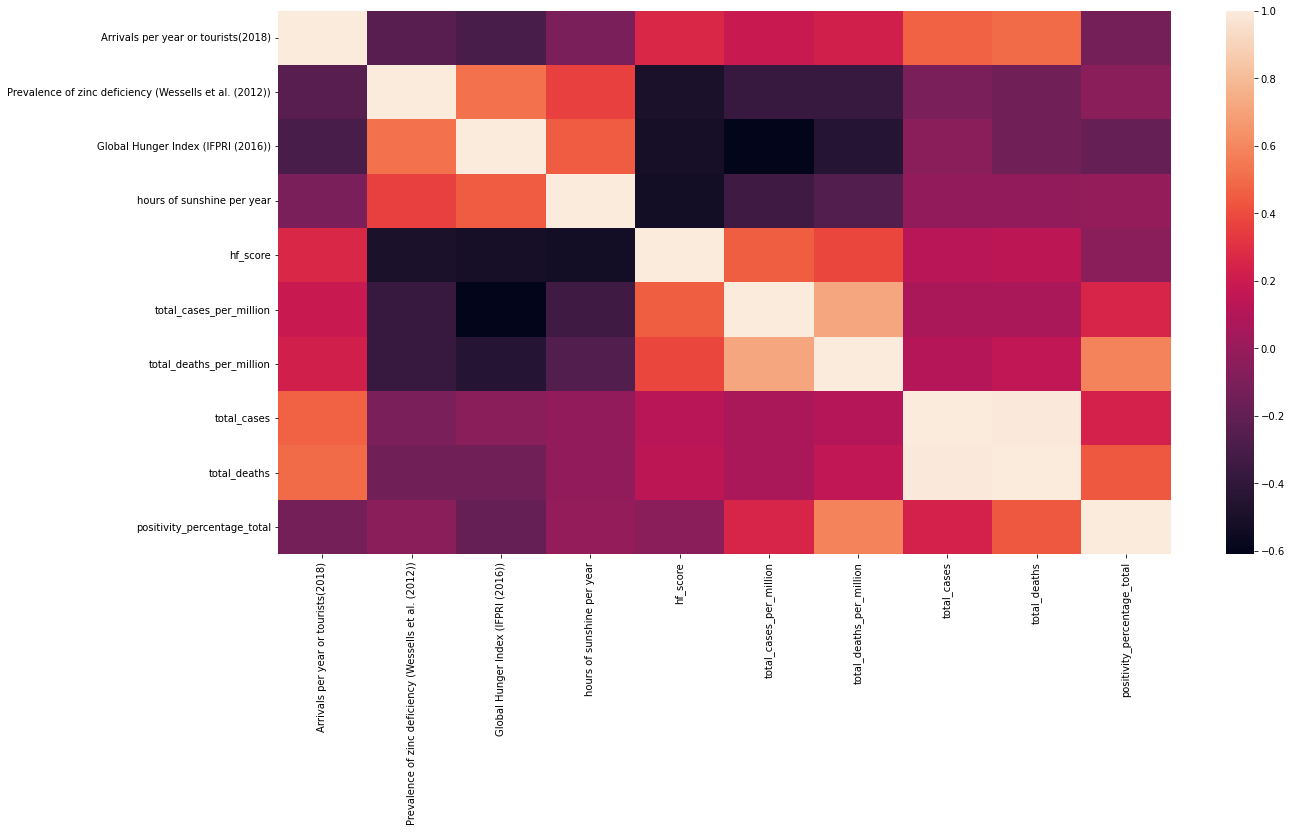

In [ ]:
df_num = df1[['Arrivals per year or tourists(2018)' ,'Prevalence of zinc deficiency (Wessells et al. (2012))' , 'Global Hunger Index (IFPRI (2016))' , 
                                'hours of sunshine per year' , 'hf_score', 'total_cases_per_million','total_deaths_per_million' , 'total_cases' 
             , 'total_deaths' ,'positivity_percentage_total']]
sns.heatmap(df_num.corr())

### A two dimensional array is created below . This array contians R values , features and dependant variables with R values higher than 0.2

In [ ]:
list_of_first_question_data = ['Arrivals per year or tourists(2018)' ,'Prevalence of zinc deficiency (Wessells et al. (2012))' , 'Global Hunger Index (IFPRI (2016))' , 
                                'hours of sunshine per year' , 'hf_score']
df_num1 = ['total_cases_per_million','total_deaths_per_million' , 'total_cases' , 'total_deaths' ,'positivity_percentage_total']
list_of_correlations_one = []
for i in list_of_first_question_data:
    df_num = df1[[i , 'total_cases_per_million','total_deaths_per_million' , 'total_cases' , 'total_deaths' ,'positivity_percentage_total']]
    for j in range(1 ,6):
        if math.sqrt((df_num.corr()[i][j])**2) > 0.2:
            list1 =[]
            list1.append(df_num1[j-1])
            list1.append(i)
            list1.append(df_num.corr()[i][j])
            list_of_correlations_one.append(list1)
print(list_of_correlations_one)

[['total_deaths_per_million', 'Arrivals per year or tourists(2018)', 0.2252565213960052], ['total_cases', 'Arrivals per year or tourists(2018)', 0.4689450670584199], ['total_deaths', 'Arrivals per year or tourists(2018)', 0.49844813117627645], ['total_cases_per_million', 'Prevalence of zinc deficiency (Wessells et al. (2012))', -0.3765731314481932], ['total_deaths_per_million', 'Prevalence of zinc deficiency (Wessells et al. (2012))', -0.37576427152415204], ['total_cases_per_million', 'Global Hunger Index (IFPRI (2016))', -0.609847649116698], ['total_deaths_per_million', 'Global Hunger Index (IFPRI (2016))', -0.45008463262919834], ['total_cases_per_million', 'hours of sunshine per year', -0.3422107725793812], ['total_deaths_per_million', 'hours of sunshine per year', -0.265723716799214], ['total_cases_per_million', 'hf_score', 0.45858735867264844], ['total_deaths_per_million', 'hf_score', 0.3828015290559922]]


### Scatter plots of all the pairs that have an R value higher than 0.2

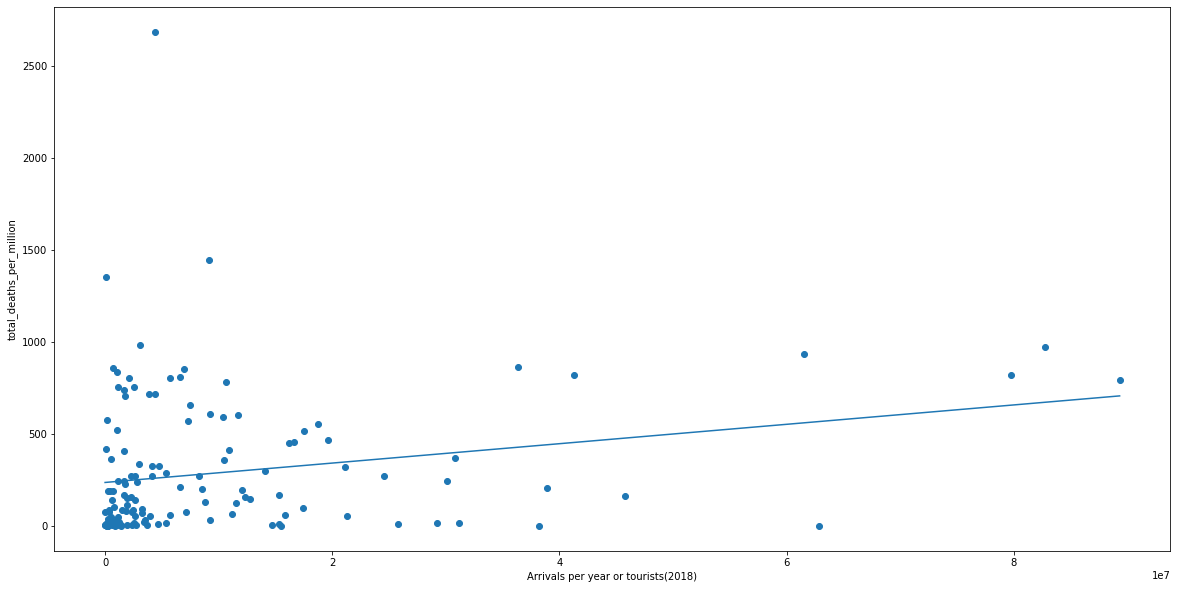

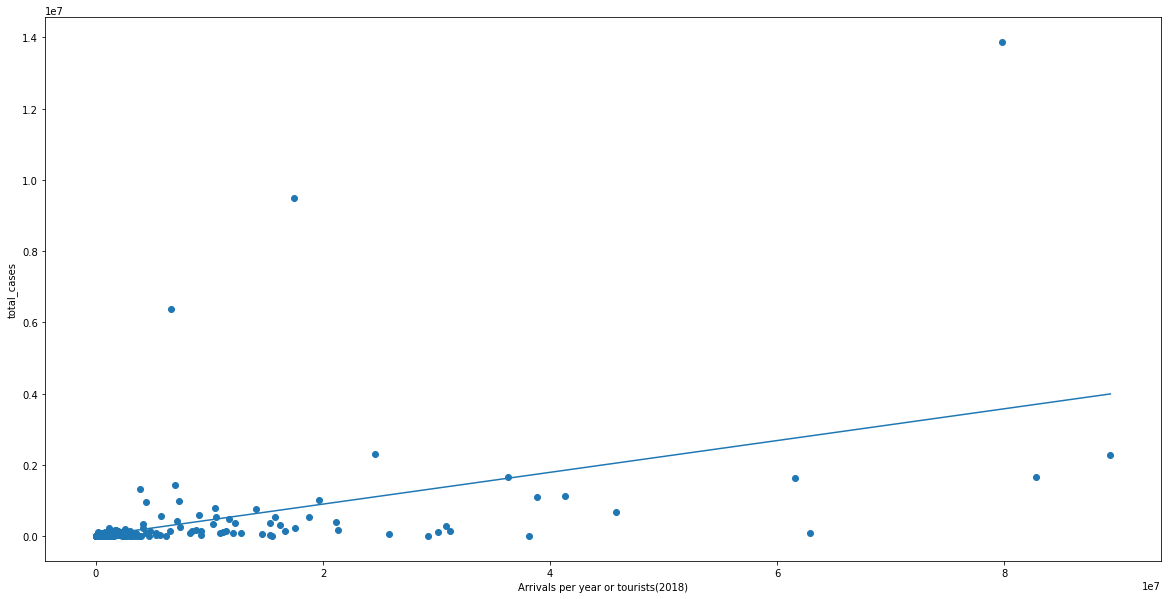

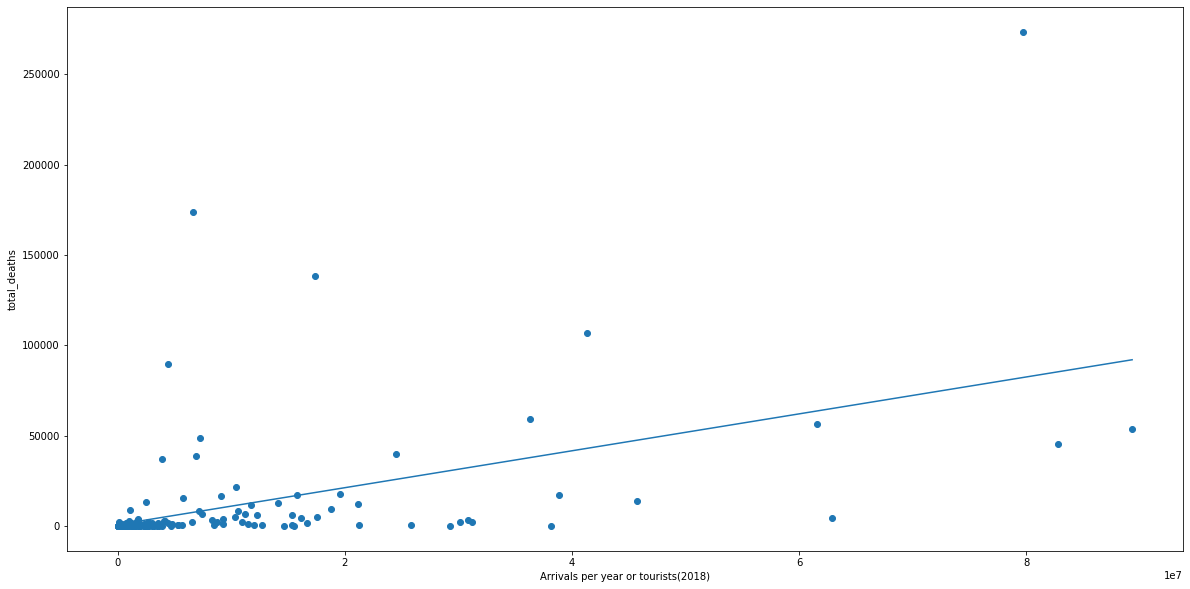

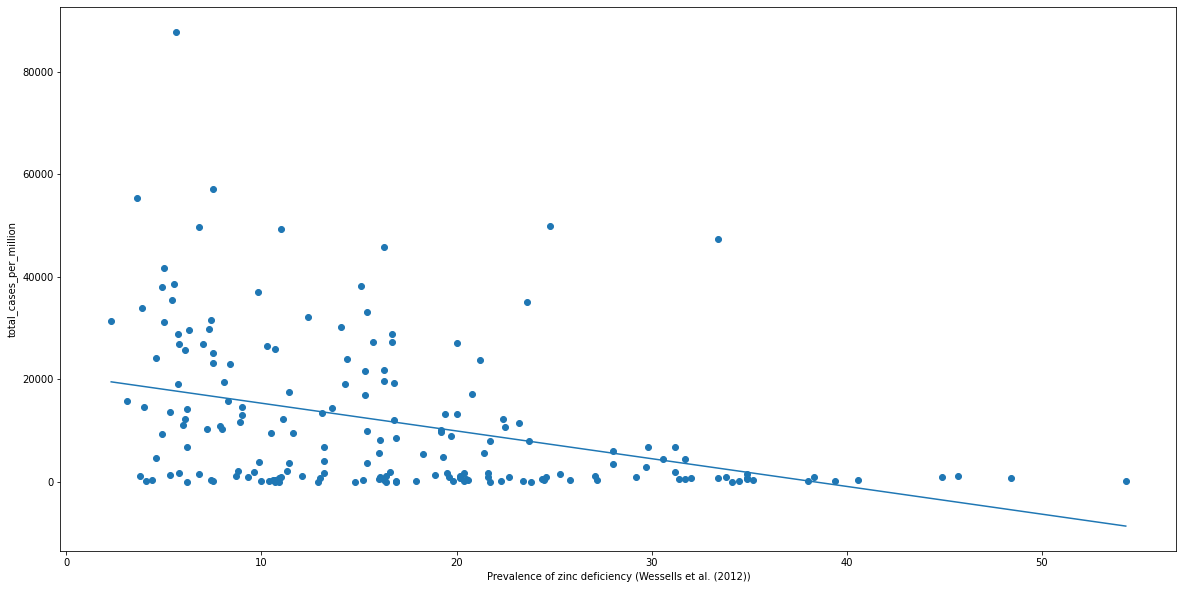

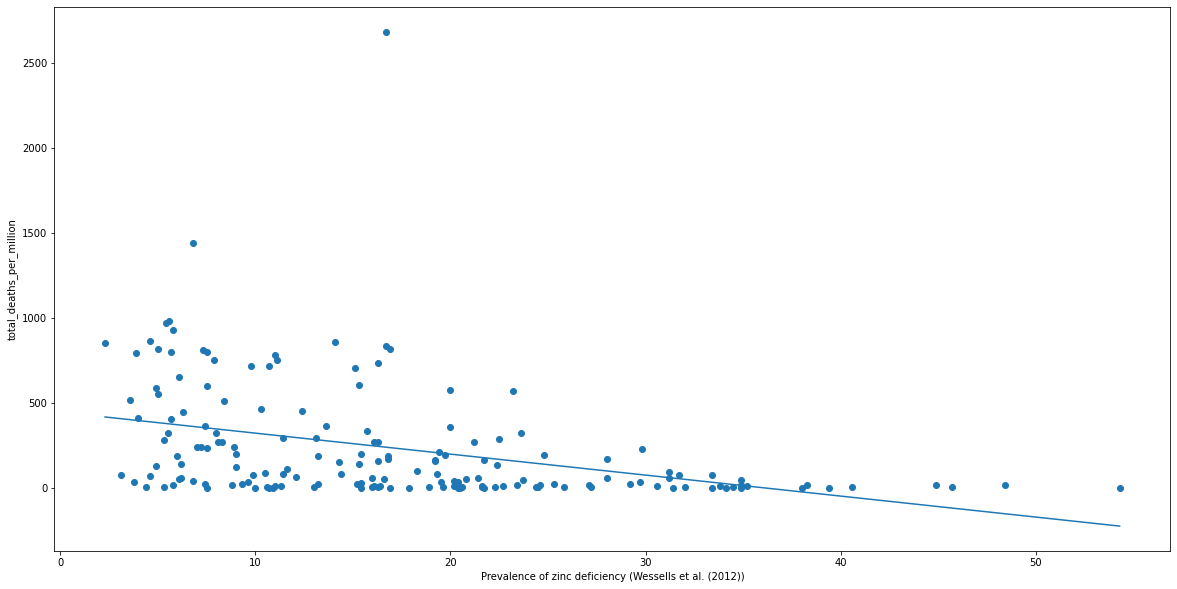

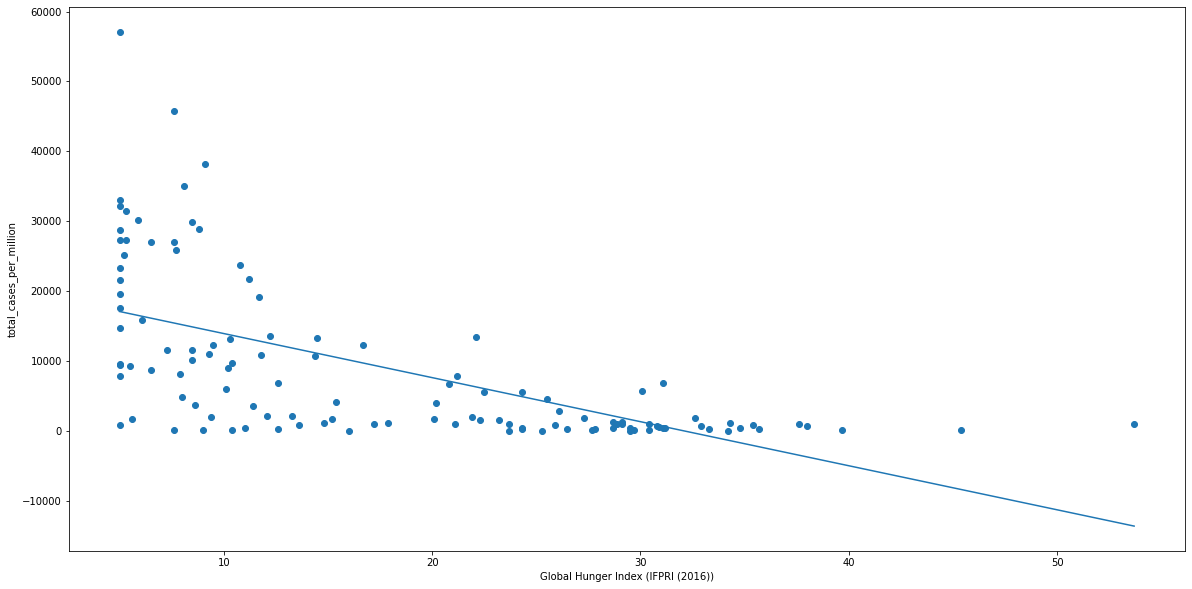

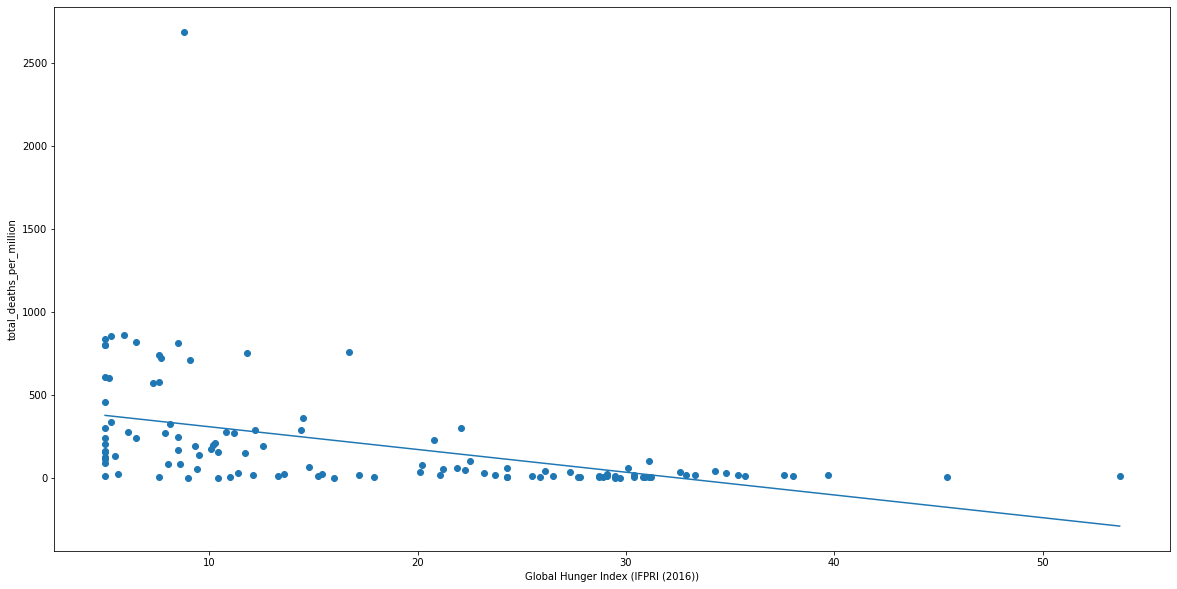

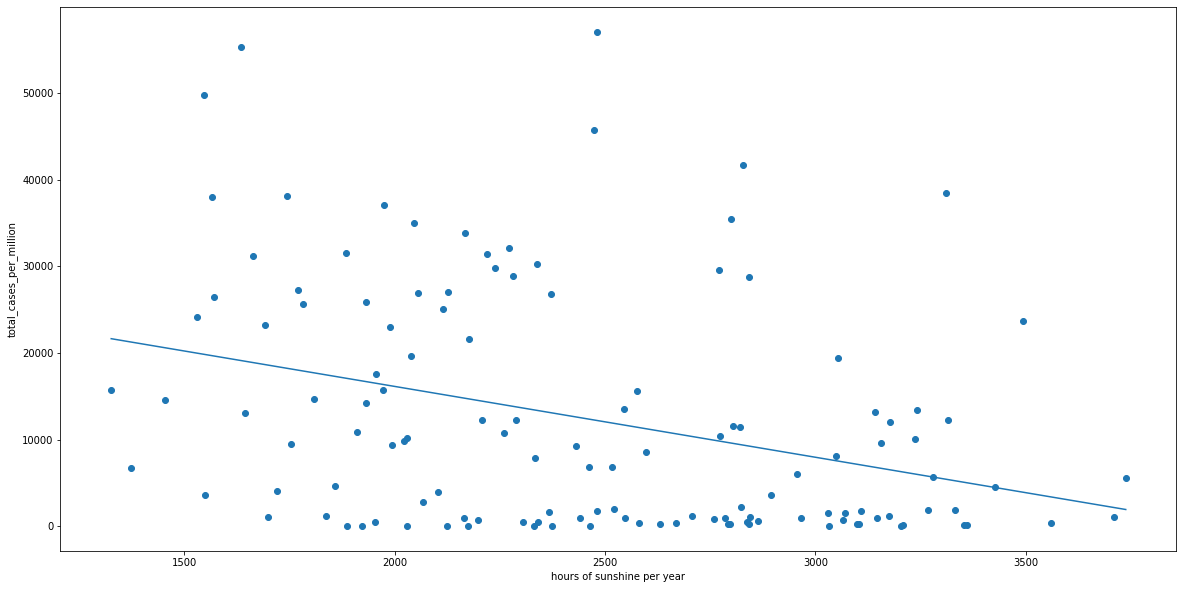

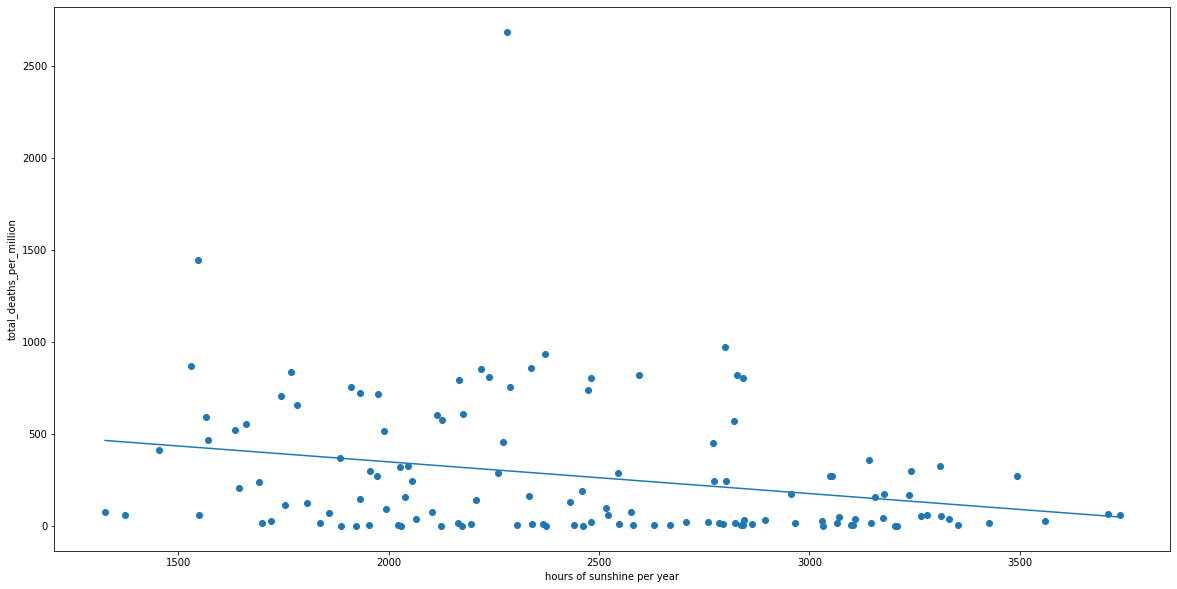

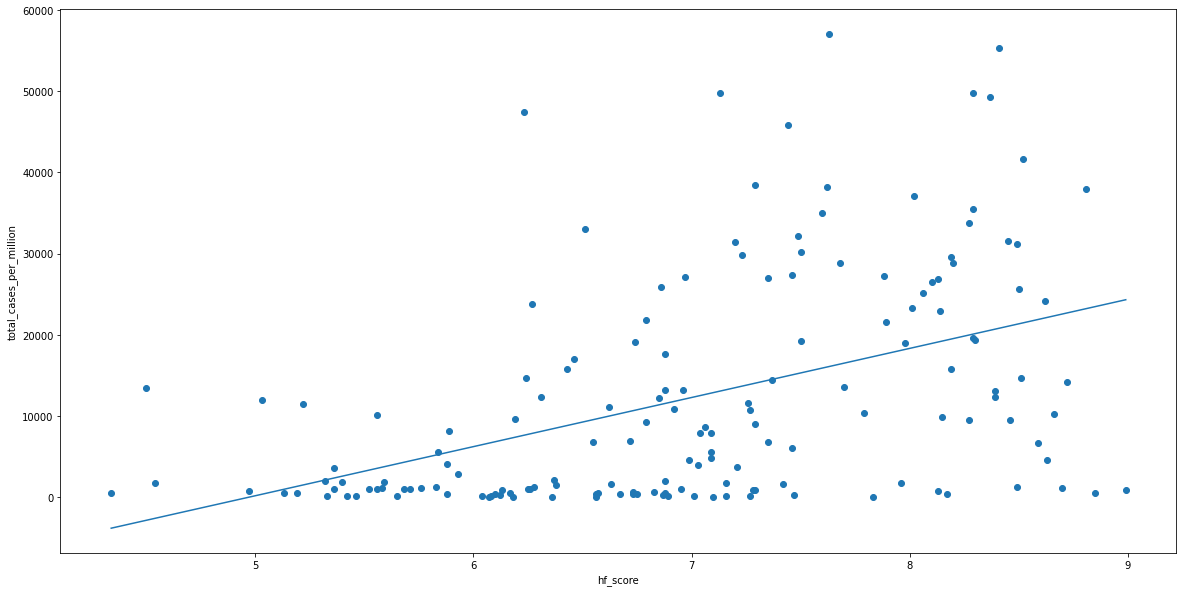

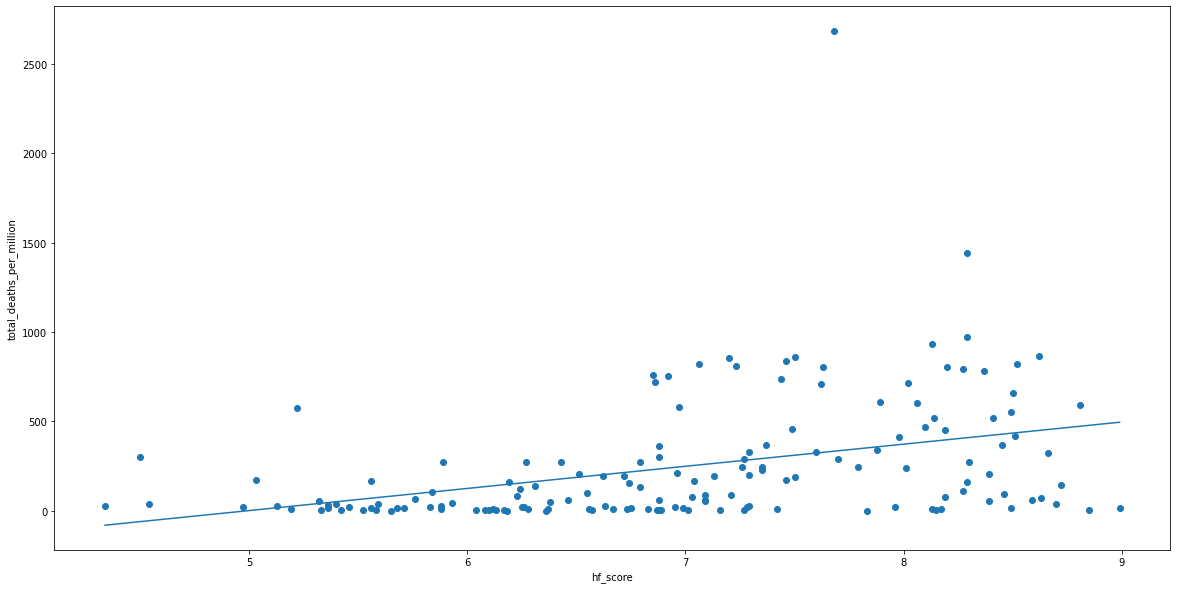

In [ ]:
for i in range(0 ,len(list_of_correlations_one)):
    plt.scatter(df1[list_of_correlations_one[i][1]] ,  df1[list_of_correlations_one[i][0]] )
    w1, w0 = ma.polyfit(ma.masked_invalid(df1[list_of_correlations_one[i][1]]), ma.masked_invalid(df1[list_of_correlations_one[i][0]]), 1)
    x_all = np.linspace(df1[list_of_correlations_one[i][1]].min(), df1[list_of_correlations_one[i][1]].max(), 100)
    plt.plot(x_all, w0 + w1 * x_all, '-')
    plt.xlabel(list_of_correlations_one[i][1])
    plt.ylabel(list_of_correlations_one[i][0])
    plt.show()
    pass

### Results in this question are quite interesting . Most of them are self explanitory . What did surprise me however , was that the higher the percentage of people dificient in Zinc , the lower the cases and deaths . This might be due to having most countries where zinc dificiency is high , being the same countries where median age is low . And we already know with enough certainity that lower median age equals lower cases and deaths . This also explains why countries with higher global hunger index have lower cases_per_million with the reason being the same as the one mentioned earlier . 

[back to the top](#main)
<a id='Q2' name='Q2'></a>
## 2. Taking into account global data , how does new daily cases and 'Covid 19 test' google trends search interest correlate?

### In this question I want to compare the change of global new cases and COVID-19 testing: google trends search interest through time. I will also compute the R value for both of those variables.

Text(0, 0.5, 'COVID-19 testing: google search interest')

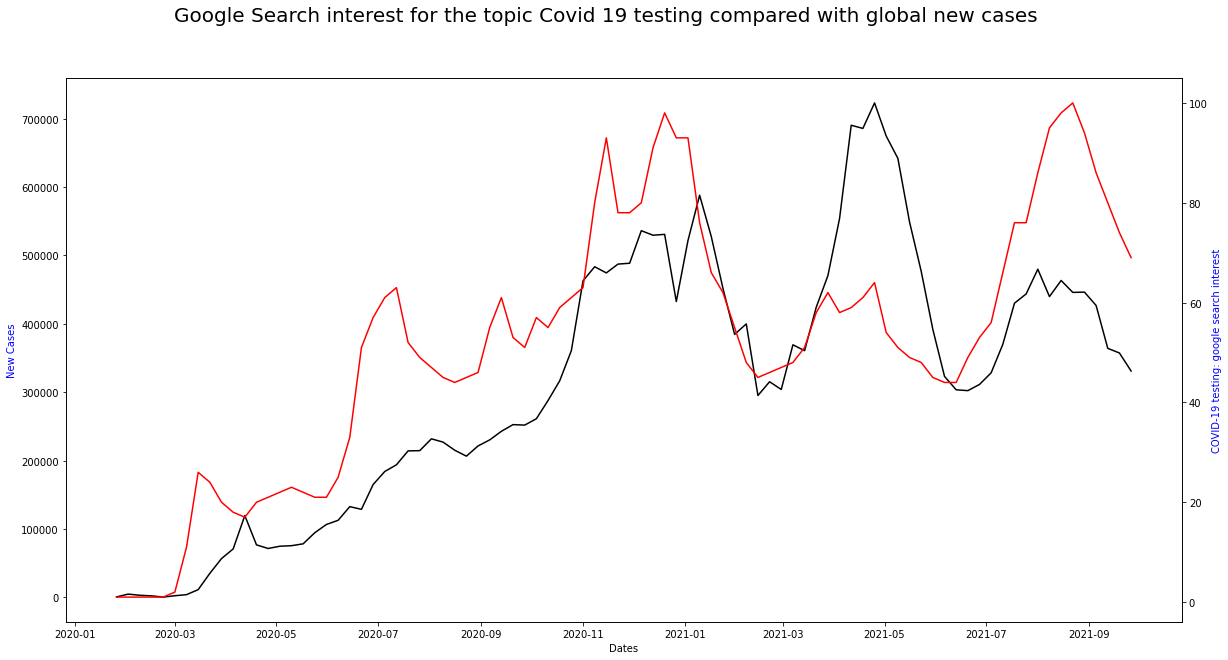

In [ ]:
#plotting a graph of new cases versus time and COVID-19 testing: google search interest versus time
fig, new_cases = plt.subplots()
cov19 = new_cases.twinx()
plt.rcParams["figure.figsize"] = (20,10)
plt.xlabel('Date')
new_cases.plot(df2['date'], df2['new_cases'], color='black')
cov19.plot(df2['date'], df2['COVID-19 testing: (Worldwide)'], color='red')
fig.suptitle('Google Search interest for the topic Covid 19 testing compared with global new cases', fontsize=20)
new_cases.set_xlabel('Dates')
new_cases.set_ylabel('New Cases', color='b')
cov19.set_ylabel('COVID-19 testing: google search interest', color='b')


In [ ]:
df_num = df2[['COVID-19 testing: (Worldwide)' ,'new_cases' ]]
print("The correlation between new cases and COVID-19 testing: google search interest is : " + str(df_num.corr()['new_cases'][0]))

The correlation between new cases and COVID-19 testing: google search interest is : 0.7819338836786516


### Results in this question are not surprising .When new cases increase people would also probably want to google for tests for Covid 19 (due to being symptomatic or precautious) and thus we see the relatively high correlation between the two variables .

[back to the top](#main)
<a id='Q3' name='Q3'></a>
## 3. After building a regression model using the added features mentioned in the first question , does the RMSE of the model decrease?

### Training the model using a random forest model using only the original features (not the added ones).Features here are considered to be all the columns from 12 to 27. As all the others are considered dependant variables . The model is built using "total_cases" as the dependant variable. 

In [ ]:
RMSE = []
#splitting dependants and independant variables
X = df1.iloc[:, 12:28].values
y = df1.iloc[:, 1].values
#replacing nan values with the mean for the feature 
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(X)
X = imputer.transform(X)
#splitting into train and test arrays
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)
#training the regressor which in this case is a random forest regressor 
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 10, random_state = 1)
regressor.fit(X_train, y_train)
#printing y_pred and y_test next to each other
y_pred = []
for i in range(0 ,X_test.shape[0] ):
    y_pred.append(regressor.predict([X_test[i]]))
y_pred_np = np.asarray(y_pred)
print("  y_pred"  , " \ty_test")
print(np.concatenate((y_pred_np.reshape(len(y_pred_np),1), y_test.reshape(len(y_test),1)),1))
from sklearn.metrics import mean_squared_error
print("\n")
print("The root mean square error using the given features: \t" + str(mean_squared_error(y_test, y_pred_np, squared=False)))
RMSE.append(mean_squared_error(y_test, y_pred_np, squared=False))

  y_pred  	y_test
[[7.0964000e+04 2.9970000e+03]
 [1.3418910e+05 1.4017200e+05]
 [1.3112500e+04 2.4487000e+04]
 [1.2142950e+05 3.2900000e+02]
 [3.9727390e+05 4.3292500e+05]
 [6.0591000e+04 6.7900000e+02]
 [2.4261170e+05 1.2945500e+05]
 [1.3085350e+05 1.7014900e+05]
 [2.5474730e+05 3.8854300e+05]
 [6.4290000e+02 5.3190000e+03]
 [6.9470360e+05 1.6564440e+06]
 [1.1651410e+05 7.5430000e+03]
 [4.5428000e+03 6.8900000e+02]
 [7.8984500e+04 3.9130000e+04]
 [2.8704910e+05 9.9992400e+05]
 [2.2118970e+05 8.1200000e+02]
 [3.0904170e+05 3.5984400e+05]
 [1.2250428e+06 1.2859000e+04]
 [1.2437109e+06 1.1223620e+06]
 [9.3685350e+05 2.2852730e+06]
 [4.2482980e+05 1.1630300e+05]
 [7.7967600e+04 1.4877500e+05]
 [1.1417607e+06 1.0946780e+06]
 [8.6128900e+04 1.4299200e+05]
 [4.6052330e+05 5.5286400e+05]
 [1.6126460e+05 2.1035000e+04]
 [1.9575000e+03 6.1300000e+02]
 [5.4911000e+03 4.9180000e+03]
 [2.8963000e+03 6.4420000e+03]
 [1.5827600e+04 1.0742000e+04]
 [1.2965490e+05 8.2470000e+04]
 [1.3360610e+05 1.834

### Training the model using a random forest model using both the original and the added features . Features here are considered to be all the columns from 12 to 33 . As all the others are considered dependant variables . The model is built using "total_cases" as the dependant variable. 

In [ ]:
#splitting dependants and independant variables
X = df1.iloc[:, 12:].values
y = df1.iloc[:, 1].values
#replacing nan values with the mean for the feature 
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer1 = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(X)
X = imputer.transform(X)
#splitting into train and test arrays
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)
#training the regressor which in this case is a random forest regressor 
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 10, random_state = 1)
regressor.fit(X_train, y_train)
#printing y_pred and y_test next to each other
y_pred = []
for i in range(0 ,X_test.shape[0] ):
    y_pred.append(regressor.predict([X_test[i]]))
y_pred_np = np.asarray(y_pred)
print("  y_pred"  , " \ty_test")
print(np.concatenate((y_pred_np.reshape(len(y_pred_np),1), y_test.reshape(len(y_test),1)),1))
#
from sklearn.metrics import mean_squared_error
print("\n")
print("The root mean square error using the given features plus the added features : \t" + str(mean_squared_error(y_test, y_pred_np, squared=False)))
RMSE.append(mean_squared_error(y_test, y_pred_np, squared=False))

  y_pred  	y_test
[[1.4318200e+04 2.9970000e+03]
 [4.0660060e+05 1.4017200e+05]
 [1.1762200e+04 2.4487000e+04]
 [3.8703900e+04 3.2900000e+02]
 [5.8566750e+05 4.3292500e+05]
 [1.0887980e+05 6.7900000e+02]
 [1.7197850e+05 1.2945500e+05]
 [2.0993680e+05 1.7014900e+05]
 [3.4109470e+05 3.8854300e+05]
 [3.0265700e+04 5.3190000e+03]
 [2.1975577e+06 1.6564440e+06]
 [1.6294100e+04 7.5430000e+03]
 [7.1875000e+03 6.8900000e+02]
 [5.1754800e+04 3.9130000e+04]
 [7.2995010e+05 9.9992400e+05]
 [7.3584500e+04 8.1200000e+02]
 [3.1916940e+05 3.5984400e+05]
 [1.8033290e+05 1.2859000e+04]
 [8.8594870e+05 1.1223620e+06]
 [2.7291610e+06 2.2852730e+06]
 [2.8664220e+05 1.1630300e+05]
 [9.6575400e+04 1.4877500e+05]
 [1.1893494e+06 1.0946780e+06]
 [1.9206050e+05 1.4299200e+05]
 [1.8826250e+05 5.5286400e+05]
 [8.1310700e+04 2.1035000e+04]
 [3.5299000e+03 6.1300000e+02]
 [1.0940200e+04 4.9180000e+03]
 [4.0919000e+03 6.4420000e+03]
 [1.4161300e+04 1.0742000e+04]
 [2.0734100e+05 8.2470000e+04]
 [1.5066220e+05 1.834

In [ ]:
print("Difference in RMSE :" + str(RMSE[0]-RMSE[1])) #printing the difference between RMSE before and after added features . 

Difference in RMSE :181103.66162923517


### Added features decreased the RMSE from 373753.42598983727 to 192649.7643606021 . That still might seem like a lot , but remember that this is the average difference between the predicted total cases and true total cases for a country, which is usually a failry big number . Models like these can be used by institutions to predict the epidemiological outcome for a specific nation with specific features . This then can be used to tighten restrictions accordingly .  